In [18]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from zoopt import Dimension, Objective, Parameter, Opt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [19]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20
K = 5

In [20]:
# Load Data
def loading_data(dataset_path):
    filepaths = []
    labels = []

    folds = os.listdir(dataset_path)
    for fold in folds:
        foldpath = os.path.join(dataset_path, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepath')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [21]:
# Change label names
def change_label_name(df, column_name):
    index = {
        'lun_Opac': 'Lung_Opacity',
        'normal': 'Normal',
        'Viral_pneu': 'Viral_pneumonia',    
    }
    df[column_name] = df[column_name].replace(index)

In [22]:
dataset_path = "/home/dell/Desktop/rk/Lung X-Ray Image"
df = loading_data(dataset_path)

In [23]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

change_label_name(df, 'labels')
data_balance = df.labels.value_counts()

Found 3475 files belonging to 3 classes.


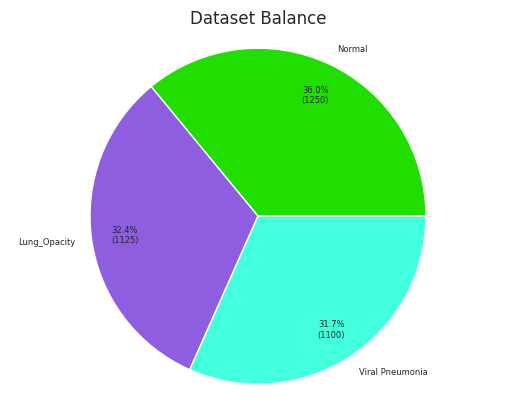

In [24]:
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

colors = ['#20df00', '#8f5ddf', '#44ffdd']
plt.pie(data_balance, autopct=custom_autopct, labels=data_balance.index, colors=colors, textprops={'fontsize':6}, pctdistance=0.8, labeldistance=1.1)
plt.title("Dataset Balance")
plt.axis("equal")
plt.show()

In [27]:
# Calculate the sizes of each dataset split
dataset_size = len(image_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

In [28]:
# Shuffle and split the dataset
image_dataset = image_dataset.shuffle(buffer_size=dataset_size, seed=123)
train_ds = image_dataset.take(train_size)
val_ds = image_dataset.skip(train_size).take(val_size)
test_ds = image_dataset.skip(train_size + val_size)

In [29]:
# Preprocessing and caching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing and rescaling layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

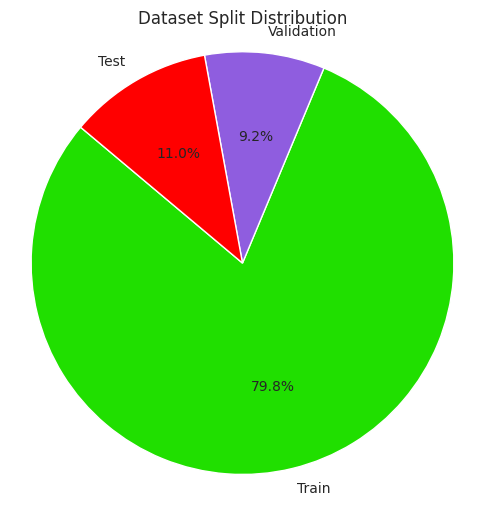

In [33]:
# Calculate split sizes
dataset_size = len(image_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Set labels and colors
labels = ['Train', 'Validation', 'Test']
colors = ['#20df00', '#8f5ddf', 'red']

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie([train_size, val_size, test_size], labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)
plt.title('Dataset Split Distribution')
plt.axis('equal')  # Equal aspect ratio for a circular pie chart
plt.show()

In [34]:

def create_model(learning_rate, dropout_rate, num_layers, num_filters):
    model = Sequential()
    model.add(resize_and_rescale)

    for i in range(num_layers):
        model.add(layers.Conv2D(num_filters, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [38]:
def evaluate_model(solution):
    params = solution.get_x()  # Retrieve the parameter values from the Solution object
    learning_rate, dropout_rate, num_layers, num_filters = params

    model = create_model(learning_rate, dropout_rate, num_layers, num_filters)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0
    )

    val_accuracy = max(history.history['val_accuracy'])  # Get the highest validation accuracy
    return 1 - val_accuracy  # Minimize 1 - accuracy (to maximize accuracy)


In [36]:
# Class Activation Mapping (CAM)
def get_cam_model(model, last_conv_layer_name="conv2d_5"):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    cam_model = models.Model([model.inputs], [last_conv_layer.output, model.output])
    return cam_model

def plot_cam(image, cam_heatmap, alpha=0.4, colormap='viridis'):
    plt.imshow(image, alpha=1)
    plt.imshow(cam_heatmap, cmap=colormap, alpha=alpha)
    plt.axis('off')
    plt.show()

In [39]:
# ZOOpt Configuration
dim = Dimension(
    4, 
    [
        [1e-5, 1e-1], #learning_rate
        [0.1, 0.5], #dropout_rate
        [2, 6], #No of layers
        [32, 256]], # No of filters
        [True, True, False, False]
        )
objective = Objective(lambda params: evaluate_model(params), dim)
parameter = Parameter(budget=100, exploration_rate=0.1)

# Optimize
solution = Opt.min(objective, parameter)
best_params = solution.get_x()
best_accuracy = 1-  solution.get_value()

print("Best Hyperparameters:")
print(f"Learning Rate: {best_params[0]}")
print(f"Dropout Rate: {best_params[1]}")
print(f"Number of Layers: {best_params[2]}")
print(f"Number of Filters: {best_params[3]}")
print(f"Best Accuracy: {best_accuracy}")



[zoopt] expected remaining running time: 84:48:47
[zoopt] x: [0.0012923980141569898, 0.4483091795428623, 3, 43]
[zoopt] value: 0.0327380895614624
Best Hyperparameters:
Learning Rate: 0.0012923980141569898
Dropout Rate: 0.4483091795428623
Number of Layers: 3
Number of Filters: 43
Best Accuracy: 0.9672619104385376


NameError: name 'model' is not defined